# EDA Along The Way

## Imports

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

## Explore V2 Fight Details Data


In [2]:
df = pd.read_csv('../../02_Data/02_Processed_Data/V2_Fight_Details.csv',index_col=0)

#### Need to duplicate and flip the data so all fighters are represented as f1

In [3]:
# Setup Columns Again
F1_Columns = [col for col in df.columns if 'f1' in col.lower()]
F2_Columns = [col for col in df.columns if 'f2' in col.lower()]
Other_Columns = [col for col in df.columns if not 'f2' in col.lower() and not 'f1' in col.lower()]

Ordered_Columns = Other_Columns + F1_Columns + F2_Columns
Flipped_Columns = Other_Columns + F2_Columns + F1_Columns

# Put Columns in Order
df = df[Ordered_Columns]

# Create Flipped df
flipped_df = df[Flipped_Columns]
flipped_df.columns = Ordered_Columns

# Concatenate df and flipped_df
df = pd.concat([df, flipped_df])

# Reset the index
df = df.reset_index().drop(columns=['index'])

#### Check out the shape of the data

In [4]:
df.shape

(4774, 107)

#### Look at the top 10 columns

In [5]:
df.columns[:10]

Index(['currentrnd', 'eventid', 'fightid', 'maxrnds', 'timestamp',
       'f1_body_significant_strikes_attempts',
       'f1_body_significant_strikes_landed', 'f1_body_total_strikes_attempts',
       'f1_body_total_strikes_landed', 'f1_clinch_body_strikes_attempts'],
      dtype='object')

In [7]:
[col for col in df.columns if 'f1' not in col and 'f2' not in col]

['currentrnd', 'eventid', 'fightid', 'maxrnds', 'timestamp']

Looks like there are generic identifiers of each event and fight.  The column ``currentrnd`` represents the round that the fight was stopped, if it was stopped early.  ``maxrnds`` is the maximum number of rounds that the fight could go if it went to a decision. 

**Subject Matter Expertise:** Normal UFC fights are 3 rounds.  Championship and card "headliners" are 5 rounds.  Card headliners are usually between veteran or rapidily rising fighters with "hype" 

timestamp is a datetime stamp - Upon inspection it is close to the date of the actual event, but does not match it.

#### Check if there the time stamp is off of the event date in a consistent way

In [10]:
# Let's inspect the time stamp
df.timestamp.describe()

count                    4774
unique                   2293
top       14:41:02 05/23/2014
freq                       18
Name: timestamp, dtype: object

#### In order to compare the time stamp to the event date, I need to bring the event date.

In [11]:
# find path for events_df
!ls ../../02_Data/01_Raw_Scraped_Data/Events/events_df.csv

../../02_Data/01_Raw_Scraped_Data/Events/events_df.csv


In [12]:
events_df = pd.read_csv('../../02_Data/01_Raw_Scraped_Data/Events/events_df.csv', index_col = 0)

In [13]:
# Look at events_df
events_df.head(2)

,Country,Date,EventId,Url,Venue
0,Australia,2013-12-06,644,/event/ufc-fight-night-hunt-bigfoot,Queensland Entertainment Centre
1,USA,2015-02-14,701,/event/ufc-fight-night-broomfield,1stBank Center


#### Create merge dataframe and merge to df

In [14]:
events_merge = events_df[['EventId','Date']]
events_merge.columns = ['eventid','date']
df = df.merge(events_merge, how = 'inner', left_on = 'eventid', right_on = 'eventid')

#### Check timestamp and date dtypes to see if I can directly subtract them

In [15]:
df[['timestamp','date']].dtypes

timestamp    object
date         object
dtype: object

#### Convert timestamp and date to date type

In [16]:
df['timestamp'] = pd.to_datetime(df['timestamp']) 
df['date'] = pd.to_datetime(df['date']) 

In [17]:
df[['timestamp','date']].dtypes

timestamp    datetime64[ns]
date         datetime64[ns]
dtype: object

#### Create timestamp_date_delta column in "days" and then to int to graph

In [18]:
df['timestamp_date'] = df.apply(lambda x: x['timestamp'] - x['date'], axis = 1).astype('timedelta64[D]').astype('int')

In [19]:
# Verify that the apply function worked correctly and the values are numbers
df['timestamp_date'].head(2)

0    472
1      2
Name: timestamp_date, dtype: int64

#### Let's try to take a look at a histogram of the different dates using seaborn

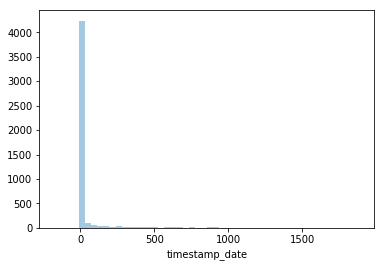

In [20]:
sns.distplot(df['timestamp_date'], kde=False)

It looks like the time stamp varies wildly in some small cases.  Basically the conclusion is that it really is not very useful since we just need date anyway.  We can go ahead and drop that column, as well as the check columns

In [21]:
df = df.drop(columns=['timestamp', 'timestamp_date'])

Let's look at the columns more

In [22]:
list(df.columns)[:5]+list(df.columns)[-5:]

['currentrnd',
 'eventid',
 'fightid',
 'maxrnds',
 'f1_body_significant_strikes_attempts',
 'f2_significant_strikes_attempts',
 'f2_significant_strikes_landed',
 'f2_total_strikes_attempts',
 'f2_total_strikes_landed',
 'date']

It looks like there are ``f1`` columns and ``f2`` columns as well as generic columns

In [23]:
# Use list comprehension to grab all f1 columns - attempts
f1_columns = [col for col in df.columns if 'f1' in col and 'attempts' in col]
f1_columns

['f1_body_significant_strikes_attempts',
 'f1_body_total_strikes_attempts',
 'f1_clinch_body_strikes_attempts',
 'f1_clinch_head_strikes_attempts',
 'f1_clinch_leg_strikes_attempts',
 'f1_clinch_significant_strikes_attempts',
 'f1_clinch_total_strikes_attempts',
 'f1_distance_body_strikes_attempts',
 'f1_distance_head_strikes_attempts',
 'f1_distance_leg_strikes_attempts',
 'f1_distance_strikes_attempts',
 'f1_grappling_submissions_attempts',
 'f1_grappling_takedowns_attempts',
 'f1_ground_body_strikes_attempts',
 'f1_ground_head_strikes_attempts',
 'f1_ground_leg_strikes_attempts',
 'f1_ground_significant_strikes_attempts',
 'f1_ground_total_strikes_attempts',
 'f1_head_significant_strikes_attempts',
 'f1_head_total_strikes_attempts',
 'f1_legs_significant_strikes_attempts',
 'f1_legs_total_strikes_attempts',
 'f1_significant_strikes_attempts',
 'f1_total_strikes_attempts']

#### Understanding and categorizing the types of metrics that we have in the data

### Metrics are broken down by:
Part of the body being attacked  Key words:  ``head, body, legs``<br>
Position when throwing strike.  Key words: ``distance, clinch, ground`` <br>
If the strike was signficant or total.  Key words: ``significant, total`` <br>
How many landed vs. attempted:  Key words ``_attempted, _landed`` <br>
The metrics are can all be combined  Example:  ``head_total_strikes_landed``, ``distance_head_strikes_attempted``<br>
There are some fighter identifier columns:  ``f1_figherid, f1_name``<br>
There are a few grappling related columns.  Some of these don't have both landed and attempted



#### Column Selector...?

In [ ]:
prefix = ['f1_','f2_']
target = ['head','body','legs']
position = ['distance','clinch','ground']
postfix = ['_attempted','_landed']

#### Look at all the "total" columns

In [24]:
f1_total = [col for col in f1_columns if 'total' in col]
f1_total

['f1_body_total_strikes_attempts',
 'f1_clinch_total_strikes_attempts',
 'f1_ground_total_strikes_attempts',
 'f1_head_total_strikes_attempts',
 'f1_legs_total_strikes_attempts',
 'f1_total_strikes_attempts']

In [25]:
df[f1_total].head(2)

,f1_body_total_strikes_attempts,f1_clinch_total_strikes_attempts,f1_ground_total_strikes_attempts,f1_head_total_strikes_attempts,f1_legs_total_strikes_attempts,f1_total_strikes_attempts
0,1.0,0.0,0.0,17.0,5.0,23.0
1,56.0,33.0,76.0,144.0,33.0,233.0


Total strikes are aggregated into body part: ``head``, ``body``, ``legs``, and position: ``ground``, ``clinch``.  Its strange that there is no ``distance`` category.  If its important, we can calculate it by taking total and subtracting the quantity from ``ground`` and ``clinch``.

#### Look at all the "signficant" columns

In [26]:
f1_significant = [col for col in f1_columns if 'significant' in col]
f1_significant

['f1_body_significant_strikes_attempts',
 'f1_clinch_significant_strikes_attempts',
 'f1_ground_significant_strikes_attempts',
 'f1_head_significant_strikes_attempts',
 'f1_legs_significant_strikes_attempts',
 'f1_significant_strikes_attempts']

``signficant`` columns match ``total`` columns

In [27]:
df[f1_significant].head(2)

,f1_body_significant_strikes_attempts,f1_clinch_significant_strikes_attempts,f1_ground_significant_strikes_attempts,f1_head_significant_strikes_attempts,f1_legs_significant_strikes_attempts,f1_significant_strikes_attempts
0,1.0,0.0,0.0,17.0,5.0,23.0
1,37.0,17.0,30.0,113.0,21.0,171.0


In [28]:
37 + 113 + 21

171

#### Look at "target" columns

In [29]:
f1_head = [col for col in f1_columns if 'head' in col]
f1_head

['f1_clinch_head_strikes_attempts',
 'f1_distance_head_strikes_attempts',
 'f1_ground_head_strikes_attempts',
 'f1_head_significant_strikes_attempts',
 'f1_head_total_strikes_attempts']

In [30]:
df[f1_head].head(2)

,f1_clinch_head_strikes_attempts,f1_distance_head_strikes_attempts,f1_ground_head_strikes_attempts,f1_head_significant_strikes_attempts,f1_head_total_strikes_attempts
0,0.0,17.0,0.0,17.0,17.0
1,9.0,78.0,26.0,113.0,144.0


In [31]:
(9+78+26)

113

In [32]:
f1_body = [col for col in f1_columns if 'body' in col]
f1_body

['f1_body_significant_strikes_attempts',
 'f1_body_total_strikes_attempts',
 'f1_clinch_body_strikes_attempts',
 'f1_distance_body_strikes_attempts',
 'f1_ground_body_strikes_attempts']

In [33]:
df[f1_body].head(2)

,f1_body_significant_strikes_attempts,f1_body_total_strikes_attempts,f1_clinch_body_strikes_attempts,f1_distance_body_strikes_attempts,f1_ground_body_strikes_attempts
0,1.0,1.0,0.0,1.0,0.0
1,37.0,56.0,5.0,29.0,3.0


In [34]:
29+5+3

37

In [35]:
f1_legs = [col for col in f1_columns if 'legs' in col or 'leg' in col]
f1_legs

['f1_clinch_leg_strikes_attempts',
 'f1_distance_leg_strikes_attempts',
 'f1_ground_leg_strikes_attempts',
 'f1_legs_significant_strikes_attempts',
 'f1_legs_total_strikes_attempts']

In [36]:
df[f1_legs].head(2)

,f1_clinch_leg_strikes_attempts,f1_distance_leg_strikes_attempts,f1_ground_leg_strikes_attempts,f1_legs_significant_strikes_attempts,f1_legs_total_strikes_attempts
0,0.0,5.0,0.0,5.0,5.0
1,3.0,17.0,1.0,21.0,33.0


The target ``legs`` is sometimes spelled ``leg``

#### Look at position striking metrics

In [37]:
f1_distance = [col for col in f1_columns if 'distance' in col]
f1_distance

['f1_distance_body_strikes_attempts',
 'f1_distance_head_strikes_attempts',
 'f1_distance_leg_strikes_attempts',
 'f1_distance_strikes_attempts']

In [38]:
df[f1_distance].head(2)

,f1_distance_body_strikes_attempts,f1_distance_head_strikes_attempts,f1_distance_leg_strikes_attempts,f1_distance_strikes_attempts
0,1.0,17.0,5.0,23.0
1,29.0,78.0,17.0,124.0


In [39]:
29+78+17

124

In [40]:
f1_clinch = [col for col in f1_columns if 'clinch' in col]
f1_clinch

['f1_clinch_body_strikes_attempts',
 'f1_clinch_head_strikes_attempts',
 'f1_clinch_leg_strikes_attempts',
 'f1_clinch_significant_strikes_attempts',
 'f1_clinch_total_strikes_attempts']

In [41]:
df[f1_clinch].head(2)

,f1_clinch_body_strikes_attempts,f1_clinch_head_strikes_attempts,f1_clinch_leg_strikes_attempts,f1_clinch_significant_strikes_attempts,f1_clinch_total_strikes_attempts
0,0.0,0.0,0.0,0.0,0.0
1,5.0,9.0,3.0,17.0,33.0


In [42]:
f1_ground = [col for col in f1_columns if 'ground' in col]
f1_ground

['f1_ground_body_strikes_attempts',
 'f1_ground_head_strikes_attempts',
 'f1_ground_leg_strikes_attempts',
 'f1_ground_significant_strikes_attempts',
 'f1_ground_total_strikes_attempts']

In [43]:
df[f1_ground].head(2)

,f1_ground_body_strikes_attempts,f1_ground_head_strikes_attempts,f1_ground_leg_strikes_attempts,f1_ground_significant_strikes_attempts,f1_ground_total_strikes_attempts
0,0.0,0.0,0.0,0.0,0.0
1,3.0,26.0,1.0,30.0,76.0


In [44]:
3+26+1

30

So now that we've looked through all of the types of columns, what can we say?  Let's write up a quick summary so we can keep going.  At the highest level, we have ``total strike attempts`` and ``significant strike attempts``.  ``total strikes`` can be broken up by **target** ``head``, ``body``, ``legs``, and by **position** ``distance``, ``clinch``, and ``ground``.  (Although the ``distance`` column needs to be imputed) <br>

``significant strike attempts`` seem to follow the same pattern.  It can be broken up by **target** or **position**, however the ``distance`` metric isn't included

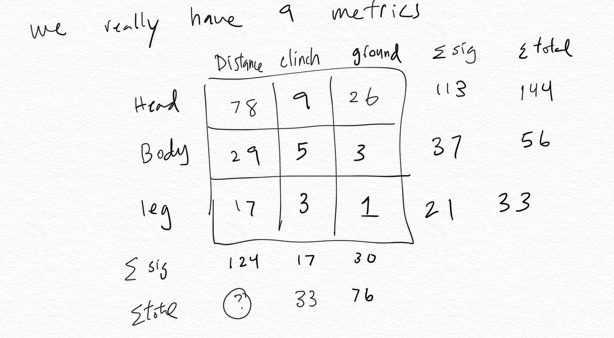

We should be able to categorize fighters based on the ratios of these numbers right?  Can I create a dataframe holding these numbers and then do stuff to it?

In [45]:
distance_head = 78
distance_body = 29
distance_leg  = 17
clinch_head   = 9
clinch_body   = 5
clinch_leg    = 3
ground_head   = 26
ground_body   = 3
ground_leg    = 1

Striking_Matrix = pd.DataFrame(
    {'distance':[distance_head,distance_body,distance_leg],
     'clinch': [clinch_head,clinch_body,clinch_leg],
     'ground': [ground_head,ground_body,ground_leg]},
    index=['head','body','leg']
)
Striking_Matrix = Striking_Matrix[['distance','clinch','ground']]

Striking_Matrix

,distance,clinch,ground
head,78,9,26
body,29,5,3
leg,17,3,1


In [46]:
Striking_Matrix.sum()

distance    124
clinch       17
ground       30
dtype: int64

In [47]:
Striking_Matrix.sum(axis=1)

head    113
body     37
leg      21
dtype: int64

In [48]:
Striking_Matrix.sum().sum()

171

In [49]:
Striking_Matrix/Striking_Matrix.sum().sum()

,distance,clinch,ground
head,0.456140,0.052632,0.152047
body,0.169591,0.029240,0.017544
leg,0.099415,0.017544,0.005848


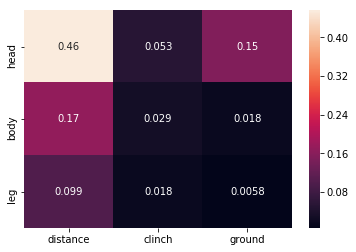

In [50]:
sns.heatmap(Striking_Matrix/Striking_Matrix.sum().sum(), annot=True)

This is interesting for 1 fighter.  I assume most fighters attack the head the most from distance and the ground.  I should be able to make some visualizations that show that as well right?

How do I do that?  Add up these 9 metrics.  In reality, I just want these 9 metrics right?  Everything else I can get.  Well, I still need "total" strikes since these don't add up to that number - but i'm still not even sure what the real distinction is...

#### Create a category for the 9 main striking stats

In [51]:
f1_9striking = [\
'f1_distance_head_strikes_attempts','f1_distance_body_strikes_attempts', 'f1_distance_leg_strikes_attempts',
'f1_clinch_head_strikes_attempts','f1_clinch_body_strikes_attempts','f1_clinch_leg_strikes_attempts',
'f1_ground_head_strikes_attempts','f1_ground_body_strikes_attempts','f1_ground_leg_strikes_attempts',]

df[f1_9striking].describe()

,f1_distance_head_strikes_attempts,f1_distance_body_strikes_attempts,f1_distance_leg_strikes_attempts,f1_clinch_head_strikes_attempts,f1_clinch_body_strikes_attempts,f1_clinch_leg_strikes_attempts,f1_ground_head_strikes_attempts,f1_ground_body_strikes_attempts,f1_ground_leg_strikes_attempts
count,4774.000000,4774.000000,4774.000000,4774.000000,4774.000000,4774.000000,4774.000000,4774.000000,4774.000000
mean,54.766024,7.784248,6.543360,4.805195,2.664432,0.638877,6.498953,0.543360,0.152074
std,52.972584,9.161902,8.783669,7.132032,4.521300,2.074024,11.879109,1.990577,0.889164
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,15.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,39.000000,5.000000,3.000000,2.000000,1.000000,0.000000,2.000000,0.000000,0.000000
75%,79.000000,11.000000,9.000000,6.000000,3.000000,0.000000,8.000000,0.000000,0.000000
max,387.000000,100.000000,89.000000,81.000000,46.000000,31.000000,119.000000,50.000000,22.000000


### Create visualization for striking matrix for all fighters

      distance   clinch   ground
head  261453.0  22940.0  31026.0
body   37162.0  12720.0   2594.0
leg    31238.0   3050.0    726.0


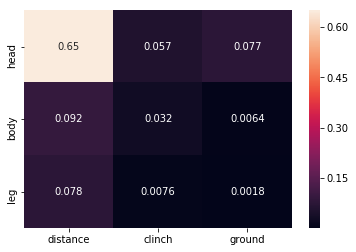

In [59]:
distance_head = df[f1_9striking].sum().iloc[0]
distance_body = df[f1_9striking].sum().iloc[1]
distance_leg  = df[f1_9striking].sum().iloc[2]
clinch_head   = df[f1_9striking].sum().iloc[3]
clinch_body   = df[f1_9striking].sum().iloc[4]
clinch_leg    = df[f1_9striking].sum().iloc[5]
ground_head   = df[f1_9striking].sum().iloc[6]
ground_body   = df[f1_9striking].sum().iloc[7]
ground_leg    = df[f1_9striking].sum().iloc[8]

Striking_Matrix = pd.DataFrame(
    {'distance':[distance_head,distance_body,distance_leg],
     'clinch': [clinch_head,clinch_body,clinch_leg],
     'ground': [ground_head,ground_body,ground_leg]},
    index=['head','body','leg']
)
Striking_Matrix = Striking_Matrix[['distance','clinch','ground']]

print(Striking_Matrix)
sns.heatmap(Striking_Matrix/Striking_Matrix.sum().sum(), annot=True)

In [62]:
Striking_Matrix.sum()/Striking_Matrix.sum().sum()

distance    0.818679
clinch      0.096076
ground      0.085245
dtype: float64

In [63]:
Striking_Matrix.sum(axis=1)/Striking_Matrix.sum().sum()

head    0.782854
body    0.130243
leg     0.086903
dtype: float64

The striking matrix aligns with expectations.  Distance head strikes are the most common strike among all types of strikes, occuring 65% of the time.  Distance striking is the most common, occuring 81% of the time.  Striking the head is the most common, occuring 78% of the time.  

#### Let's try to look at the non-striking metrics for grappling and submissions as well, so we can eventually try to figure out what kind of fighter someone is based on their fight stats (Striker, Ground and Pound, Submission Artist, Well Rounded)

In [79]:
f1_grappling = [col for col in df.columns if 'f1' in col and  'grappling' in col]
f1_grappling

['f1_grappling_standups_landed',
 'f1_grappling_submissions_attempts',
 'f1_grappling_takedowns_attempts',
 'f1_grappling_takedowns_landed']

#### Split into attempts and landed

In [77]:
f1_grappling_att = [col for col in df.columns if 'f1' in col and 'grappling' in col and 'attempts' in col]
f1_grappling_att

['f1_grappling_submissions_attempts', 'f1_grappling_takedowns_attempts']

In [78]:
f1_grappling_land = [col for col in df.columns if 'f1' in col and 'grappling' in col and 'landed' in col]
f1_grappling_land

['f1_grappling_standups_landed', 'f1_grappling_takedowns_landed']

#### Grappling
For ``takedowns`` we have both ``_attempted`` and ``_landed``. <br>
For ``standups`` we only have ``_landed``.  This is because fighters are basically always trying to stand up if they can if they have been taken down and trying to track every scramble to stand up would be very difficult <br>
For ``submissions`` we only have ``_attempted``.  This is because if a fighter lands a ``submission`` then the fight is over.<br>

In [84]:
[col for col in df.columns if 'f1' in col and 'knock' in col]

['f1_knock_down_landed']

#### Knockdowns
We've looked at all the other metrics.  There is one left:  ``knock_down``.  Similar to ``standups`` this is only available as ``_landed`` since the fighter is attempting to knock down their opponent with every strike.

## Next, let's try to compare standup fighters vs. ground fighters

**Subject Matter Expertise:** At a very coarse level, fighters are either more "standup" fighters or "ground" fighters.  Standup fighters are pretty much all strikers, though they will differ in if they prefer punching, knees or fighting "inside" in the clinch up against the cage.  Ground fighters primarily come in 2 flavors:  "ground and pound" fighters who try to take their opponent to the ground and then strike them whie they are on top of them, and "submission" fighters who try to take their opponent to the ground, improve their position and then submit their opponents.

Let's try to look at the fighters metrics and see if we can determine if a fighter is a standup vs. ground fighter.  The number of ``take downs attempted`` is probably the best proxy for a ground fighter, since the more attempts, means the more they want to get the fight to the ground

In [91]:
df['f1_grappling_takedowns_attempts'].head(4)

0     0.0
1    10.0
2     2.0
3     1.0
Name: f1_grappling_takedowns_attempts, dtype: float64

#### Let's first look at how many take downs each fighter usually attempts in a fight.  How many is "normal"?

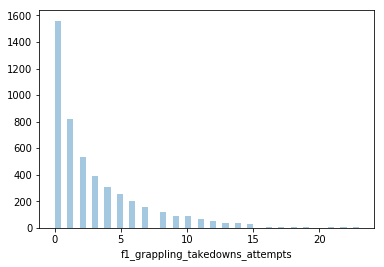

In [89]:
# Try a histogram
sns.distplot(df['f1_grappling_takedowns_attempts'], kde=False)

In [90]:
df['f1_grappling_takedowns_attempts'].mean()

2.9252199413489737

It looks like the average number of take downs per fight by a single fighter is just under 3.  However, looking at the histogram, we can see that in many fights, the fighter doesn't even try any take downs at all.  In some extreme cases, a fighter can try over 20 times to take their opponent down

**Question:**  In what percent of the fights does the fighter not even try to take their opponent down?

In [97]:
1 - df['f1_grappling_takedowns_attempts'].map(lambda x: 1 if x > 0 else 0).mean()

0.326770004189359

**Answer:**  It looks like 32% of the fights, the fighter doesn't even try to take their opponent down.

#### First, let's also create a histogram for total significant strikes and calculate the average per fight
We already have the column in the data.  It is ``f1_significant_strikes_attempts``

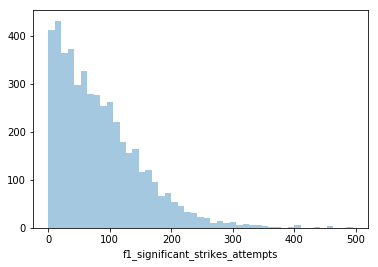

In [98]:
sns.distplot(df['f1_significant_strikes_attempts'], kde=False)

In [99]:
df['f1_significant_strikes_attempts'].mean()

84.24926686217009

In [100]:
1 - df['f1_significant_strikes_attempts'].map(lambda x: 1 if x > 0 else 0).mean()

0.003770423125261879

#### Quick Summary about total strikes
On average, a fighter will attempt 84 strikes per fight.  This can go all the way up to 500 in a single fight.  0.3% of UFC fights had a fighter not attempt to throw a single strike.

### How can I relate striking vs. take downs?  
The absolute numbers are very different.  On average 84 strikes are thrown.  Take downs on average as we've seen is about 3 per fight...  Is it okay to just divide them?    (We will use significant strikes)

Total Significant Strikes Attempted vs. Take Downs Attempted?

In [102]:
84/3

28.0

Here is a problem.  What happens if there are zero take downs in the fight?  The metric doesn't even make sense anymore...  Can I also divide by the total number of strikes?  So like:

In [103]:
(84/3)/84

0.3333333333333333

In [105]:
# First look at some data
df[['f1_significant_strikes_attempts','f1_grappling_takedowns_attempts']].head(10)

,f1_significant_strikes_attempts,f1_grappling_takedowns_attempts
0,23.0,0.0
1,171.0,10.0
2,84.0,2.0
3,111.0,1.0
4,49.0,0.0
5,49.0,0.0
6,93.0,7.0
7,90.0,1.0
8,51.0,1.0
9,105.0,0.0


#### There has to be some formula that will give me a ratio between 1 and 0 for how much of a "striker" someone is right?
Someone who attemts 0 take downs is 100% striker regardless of the number of strikes they attempted

In [107]:
7/93

0.07526881720430108

In [108]:
1/90

0.011111111111111112

Let's do strikes over take downs since the number is more sensible.  On average, fighters throw 28 strikes per take down attempt.  

f1_grappling_takedowns_attempts
f1_significant_strikes_attempts

In [ ]:
df['f1_takedowns_per_strike'] =

In [112]:
f1_takedowns_per_strike = df.apply(lambda x: x['f1_grappling_takedowns_attempts']/x['f1_significant_strikes_attempts'] \
         if x['f1_significant_strikes_attempts']!=0 else 0, axis=1)

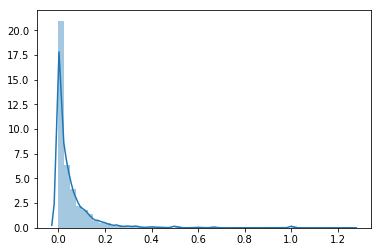

In [113]:
sns.distplot(f1_takedowns_per_strike)